In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1uvszLurLwWeWjqEjk7FuGL68VspWsRMN'}) 
downloaded.GetContentFile('Consumer_Complaints_test_share.csv')

In [0]:
downloaded = drive.CreateFile({'id':'1K-Vfw1VLc9EosJiyXRrQH3-c51esMUac'}) 
downloaded.GetContentFile('Consumer_Complaints_train.csv')

In [0]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import math
from sklearn.model_selection import train_test_split,KFold
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neural_network import *
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import StandardScaler
import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#datafile_train=r"C:\Users\MANOJ GARIKAPATI\Python_ML\Project_1\P1 Data\Consumer_Complaints_train.csv"
#datafile_test=r"C:\Users\MANOJ GARIKAPATI\Python_ML\Project_1\P1 Data\Consumer_Complaints_test_share.csv"
cd_train=pd.read_csv('Consumer_Complaints_train.csv')
cd_test=pd.read_csv('Consumer_Complaints_test_share.csv')

In [122]:
cd_train.dtypes

Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                object
Consumer disputed?              object
Complaint ID                     int64
dtype: object

In [123]:
cd_train.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2014-05-15,Credit card,NaN,Billing statement,NaN,NaN,NaN,Wells Fargo & Company,MI,48342,Older American,NaN,Web,2014-05-16,Closed with explanation,Yes,No,856103
1,2014-09-18,Bank account or service,(CD) Certificate of deposit,"Making/receiving payments, sending money",NaN,NaN,NaN,Santander Bank US,PA,18042,NaN,NaN,Referral,2014-09-24,Closed,Yes,No,1034666
2,2014-03-13,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Equifax,CA,92427,NaN,NaN,Referral,2014-04-03,Closed with non-monetary relief,Yes,No,756363
3,2015-07-17,Credit card,NaN,Billing statement,NaN,"My credit card statement from US Bank, XXXX. X...",Company chooses not to provide a public response,U.S. Bancorp,GA,305XX,Older American,Consent provided,Web,2015-07-17,Closed with monetary relief,Yes,No,1474177
4,2014-11-20,Credit card,NaN,Transaction issue,NaN,NaN,NaN,Bank of America,MA,02127,NaN,NaN,Web,2014-11-28,Closed with explanation,Yes,No,1132572


In [124]:
cd_train.shape

(478421, 18)

In [125]:
cd_train.loc[cd_train['State']=='MI','ZIP code']

0         48342
48        48217
53        49201
109       48335
164       48164
191       48382
226       48230
259       48601
333       48216
401       48134
422       49685
428       49426
468       48820
513       48095
550       483XX
567       48130
802       489XX
814       48221
824       49424
870       49002
885       48141
935       49009
937       48377
970       48532
1076      49242
1088      48076
1247      482XX
1269      48312
1303      484XX
1318      48234
          ...  
477196    48212
477294    48238
477320    48301
477341    49004
477373    48034
477383    483XX
477386    48197
477396    48085
477442    49321
477456    49504
477522    49418
477589    48827
477721    482XX
477830    49512
477877    49302
477980    49418
477984    481XX
478000    48045
478015    48054
478037    48382
478107    48150
478126    48462
478148    48122
478182    48103
478254    48382
478287    48228
478310    48178
478345    48811
478375    48127
478384    49546
Name: ZIP code, Length: 

In [126]:
cd_train["Consumer disputed?"].value_counts()

No     376990
Yes    101431
Name: Consumer disputed?, dtype: int64

In [127]:
cd_train['Company'].value_counts(dropna=False).shape

(3276,)

In [128]:
cd_train['Product'].value_counts(dropna=False)

Mortgage                   156175
Debt collection             86544
Credit reporting            81115
Credit card                 57358
Bank account or service     54403
Consumer Loan               18599
Student loan                14918
Money transfers              3349
Payday loan                  3219
Prepaid card                 2226
Other financial service       507
Virtual currency                8
Name: Product, dtype: int64

In [129]:
cd_train['Sub-issue'].value_counts().shape

(68,)

In [130]:
cd_train['Issue'].value_counts()

Loan modification,collection,foreclosure    80302
Incorrect information on credit report      58527
Loan servicing, payments, escrow account    51403
Cont'd attempts collect debt not owed       36367
Account opening, closing, or management     23568
Disclosure verification of debt             16235
Communication tactics                       15312
Deposits and withdrawals                    14721
Application, originator, mortgage broker    11201
Billing disputes                             9600
Credit reporting company's investigation     9492
Other                                        9442
Managing the loan or lease                   8905
Problems caused by my funds being low        7758
False statements or representation           7074
Unable to get credit report/credit score     7060
Dealing with my lender or servicer           6460
Improper contact or sharing of info          6182
Problems when you are unable to pay          5921
Settlement process and costs                 5834


In [131]:
len(cd_train["Complaint ID"].unique().tolist())

478421

In [132]:
cd_train['Company public response'].value_counts(dropna=False)

NaN                                                                                                                        388029
Company chooses not to provide a public response                                                                            41915
Company has responded to the consumer and the CFPB and chooses not to provide a public response                             25672
Company believes it acted appropriately as authorized by contract or law                                                    16040
Company believes complaint caused principally by actions of third party outside the control or direction of the company      1460
Company believes the complaint is the result of a misunderstanding                                                           1418
Company disputes the facts presented in the complaint                                                                        1395
Company believes complaint is the result of an isolated error                             

In [133]:
cd_train['Company response to consumer'].value_counts(dropna=False)

Closed with explanation            354310
Closed with non-monetary relief     61491
Closed with monetary relief         32925
Closed without relief               14145
Closed                              11365
Closed with relief                   4184
Untimely response                       1
Name: Company response to consumer, dtype: int64

In [134]:
sum(cd_train["Tags"].isna())/cd_train.shape[0]

0.8595253970875024

In [135]:
cd_train["Tags"].value_counts(dropna=False)

NaN                              411215
Older American                    39064
Servicemember                     22592
Older American, Servicemember      5550
Name: Tags, dtype: int64

In [136]:
cd_train["Tags"].unique()

array(['Older American', nan, 'Older American, Servicemember',
       'Servicemember'], dtype=object)

In [137]:
len(cd_train["Consumer complaint narrative"].unique())

74020

In [138]:
len(cd_train["Product"].unique())

12

In [139]:
cd_train.isna().sum()

Date received                        0
Product                              0
Sub-product                     138473
Issue                                0
Sub-issue                       292625
Consumer complaint narrative    403327
Company public response         388029
Company                              0
State                             3839
ZIP code                          3848
Tags                            411215
Consumer consent provided?      342934
Submitted via                        0
Date sent to company                 0
Company response to consumer         0
Timely response?                     0
Consumer disputed?                   0
Complaint ID                         0
dtype: int64

In [140]:
cd_train['Date received'].max()

'2016-09-23'

In [141]:
cd_train['Date received'].min()

'2011-12-01'

In [142]:
cd_train['Submitted via'].value_counts(dropna=False)

Web            313916
Referral        91352
Phone           34417
Postal mail     31448
Fax              7032
Email             256
Name: Submitted via, dtype: int64

In [143]:
cd_train['Timely response?'].value_counts(dropna=False)

Yes    470277
No       8144
Name: Timely response?, dtype: int64

In [144]:
cd_train['Consumer disputed?'].value_counts(dropna=False)

No     376990
Yes    101431
Name: Consumer disputed?, dtype: int64

In [0]:
for col in ['Date received','Date sent to company']:
    cd_train[col]=pd.to_datetime(cd_train[col],infer_datetime_format=True)
    cd_test[col]=pd.to_datetime(cd_test[col],infer_datetime_format=True)

In [0]:
cd_train['day_diff']=pd.to_numeric(cd_train['Date sent to company']-cd_train['Date received'])
cd_test['day_diff']=pd.to_numeric(cd_test['Date sent to company']-cd_test['Date received'])

In [0]:
##Create features about complaint submitted time
cd_train['Date_received_year'] = cd_train['Date received'].apply(lambda x: x.year)
cd_train['Date_received_month'] = cd_train['Date received'].apply(lambda x: x.month)
cd_train['Date_received_day'] = cd_train['Date received'].apply(lambda x: x.day)
cd_test['Date_received_year'] = cd_test['Date received'].apply(lambda x: x.year)
cd_test['Date_received_month'] = cd_test['Date received'].apply(lambda x: x.month)
cd_test['Date_received_day'] = cd_test['Date received'].apply(lambda x: x.day)

In [0]:
for col in ['Date received','Date sent to company']:
    cd_train.drop([col],1,inplace=True)
    cd_test.drop([col],1,inplace=True)

In [149]:
for col in cd_train.select_dtypes(['object']).columns:
    print(col,':',cd_train[col].nunique())

Product : 12
Sub-product : 47
Issue : 95
Sub-issue : 68
Consumer complaint narrative : 74019
Company public response : 10
Company : 3276
State : 62
ZIP code : 25962
Tags : 3
Consumer consent provided? : 4
Submitted via : 6
Company response to consumer : 7
Timely response? : 2
Consumer disputed? : 2


In [150]:
cd_train.isnull().sum()

Product                              0
Sub-product                     138473
Issue                                0
Sub-issue                       292625
Consumer complaint narrative    403327
Company public response         388029
Company                              0
State                             3839
ZIP code                          3848
Tags                            411215
Consumer consent provided?      342934
Submitted via                        0
Company response to consumer         0
Timely response?                     0
Consumer disputed?                   0
Complaint ID                         0
day_diff                             0
Date_received_year                   0
Date_received_month                  0
Date_received_day                    0
dtype: int64

In [0]:
for col in ['Sub-product','Sub-issue','Consumer complaint narrative',
            'Company public response','Tags','Consumer consent provided?']:
    varname=col.replace('-','_').replace('?','').replace(" ",'_')+'_isNan'
    cd_train[varname]=np.where(pd.isnull(cd_train[col]),1,0)
    cd_train.drop([col],1,inplace=True)
    cd_test[varname]=np.where(pd.isnull(cd_test[col]),1,0)
    cd_test.drop([col],1,inplace=True)

In [152]:
cd_train.head(4)

,Product,Issue,Company,State,ZIP code,Submitted via,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,day_diff,Date_received_year,Date_received_month,Date_received_day,Sub_product_isNan,Sub_issue_isNan,Consumer_complaint_narrative_isNan,Company_public_response_isNan,Tags_isNan,Consumer_consent_provided_isNan
0,Credit card,Billing statement,Wells Fargo & Company,MI,48342,Web,Closed with explanation,Yes,No,856103,86400000000000,2014,5,15,1,1,1,1,0,1
1,Bank account or service,"Making/receiving payments, sending money",Santander Bank US,PA,18042,Referral,Closed,Yes,No,1034666,518400000000000,2014,9,18,0,1,1,1,1,1
2,Credit reporting,Incorrect information on credit report,Equifax,CA,92427,Referral,Closed with non-monetary relief,Yes,No,756363,1814400000000000,2014,3,13,1,0,1,1,1,1
3,Credit card,Billing statement,U.S. Bancorp,GA,305XX,Web,Closed with monetary relief,Yes,No,1474177,0,2015,7,17,1,1,0,0,0,0


In [153]:
for col in cd_train.select_dtypes(['object']).columns:
    print(col,':',cd_train[col].nunique())

Product : 12
Issue : 95
Company : 3276
State : 62
ZIP code : 25962
Submitted via : 6
Company response to consumer : 7
Timely response? : 2
Consumer disputed? : 2


In [0]:
for col in ['ZIP code','Company']:
    cd_train.drop([col],1,inplace=True)
    cd_test.drop([col],1,inplace=True)

In [0]:
cd_train['Consumer disputed?']=np.where(cd_train['Consumer disputed?']=="Yes",1,0)

In [0]:
k=cd_train['Issue'].value_counts()
for val in k.axes[0][0:10]:
    varname='Issue_'+val.replace(',','_').replace(' ','_')
    cd_train[varname]=np.where(cd_train['Issue']==val,1,0)
    cd_test[varname]=np.where(cd_test['Issue']==val,1,0)
del cd_train['Issue']
del cd_test['Issue']

In [157]:
for col in cd_train.select_dtypes(['object']).columns:
    print(col,':',cd_train[col].nunique())

Product : 12
State : 62
Submitted via : 6
Company response to consumer : 7
Timely response? : 2


In [158]:
k=cd_train['State'].value_counts()
k.axes[0][0:15]

Index(['CA', 'FL', 'TX', 'NY', 'GA', 'NJ', 'PA', 'IL', 'VA', 'MD', 'OH', 'NC',
       'MI', 'AZ', 'WA'],
      dtype='object')

In [0]:
k=cd_train['State'].value_counts()
for val in k.axes[0][0:15]:
    varname='State_'+val.replace(',','_').replace(' ','_')
    cd_train[varname]=np.where(cd_train['State']==val,1,0)
    cd_test[varname]=np.where(cd_test['State']==val,1,0)
del cd_train['State']
del cd_test['State']

In [0]:
for col in ['Product','Submitted via','Company response to consumer','Timely response?']:
    
    temp=pd.get_dummies(cd_train[col],prefix=col,drop_first=True)
    cd_train=pd.concat([temp,cd_train],1)
    cd_train.drop([col],1,inplace=True)
    
    temp=pd.get_dummies(cd_test[col],prefix=col,drop_first=True)
    cd_test=pd.concat([temp,cd_test],1)
    cd_test.drop([col],1,inplace=True)

In [0]:
x=cd_train.drop(['Consumer disputed?','Complaint ID'],1)
y=cd_train['Consumer disputed?']

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
clf=LogisticRegression(class_weight='balanced')

In [176]:
#ld_train1,ld_train2=train_test_split(cd_train,test_size=0.2,random_state=2)
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(x, y):
    print("Train:", train_index, "Test:", test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#x1=ld_train1.drop(['Consumer disputed?','Complaint ID'],1)
#y1=ld_train1['Consumer disputed?']
#x2=ld_train2.drop(['Consumer disputed?','Complaint ID'],1)
#y2=ld_train2['Consumer disputed?']

Train: [340756 284343  57339 ... 280676 221528 401206] Test: [218196 359053  25215 ... 427356 237225   2778]


In [0]:

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [178]:
clf.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [0]:
prediction=clf.predict(x_test)

In [0]:
from sklearn.metrics import roc_auc_score

In [181]:
roc_auc_score(y_test,prediction)

0.5794417453460907

In [194]:
clf.fit(x,y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [0]:
act_test = cd_test.drop('Complaint ID',1)

In [0]:
from scipy.stats import randint as sp_randint
param_dist_rf = {"n_estimators":[10,100,500,700],
              "max_depth":[10,20,30,40,50,60,70],
              "max_features": sp_randint(30, 50),
              "min_samples_split": sp_randint(5, 11),
              "min_samples_leaf": sp_randint(5, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              'class_weight':['balanced']}

In [0]:
#Fitting on validation train data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold, RandomizedSearchCV
n_iter_search = 20
rf_clf = RandomForestClassifier(verbose=1,n_jobs=-1)
random_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist_rf,
                                   n_iter=n_iter_search)
random_search.fit(x_train,y_train)
#This takes quite some time to execute and increases with number of iterations

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  1

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_jobs=-1)

In [0]:
predictions_rf = clf_rf.predict(x_test)

In [210]:
roc_auc_score(y_test,predictions_rf)

0.5363501849937491

In [0]:
predictions = clf.predict(act_test)

In [0]:
test_preds=np.where(predictions==1,"Yes","No")

In [0]:
df_test=pd.DataFrame(list(zip(cd_test['Complaint ID'],test_preds)),columns=["Complaint ID","Consumer disputed?"])

In [0]:
df_test.to_csv("Manoj_Garikapati_P1_Part2.csv")
file = drive.CreateFile({'parents':[{u'id': '1TG1ya18fxuKEcTtG-Jzt--oTm0nazkk2'}]}) 
file.SetContentFile("Manoj_Garikapati_P1_Part2.csv")
file.Upload()

In [206]:
df_test.shape

(119606, 2)

In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, X_test, y_true):
    cm = confusion_matrix(y_true, model.predict(X_test))

    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[42056 33343]
 [ 8092 12194]]


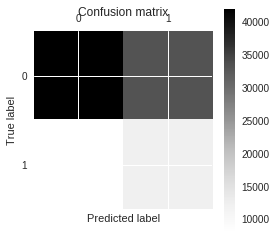

In [186]:
plot_confusion_matrix(clf, x_test, y_test)

In [187]:
clf_BNB = BernoulliNB()
clf_BNB.fit(x_train,y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [0]:
y2_pred = clf_BNB.predict(x_test)

In [190]:
roc_auc_score(y_test,y2_pred)

0.49999812198943877

In [191]:
clf_GNB = GaussianNB()
clf_GNB.fit(x_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [192]:
y2_pred_GB = clf_GNB.predict(x_test)
roc_auc_score(y_test,y2_pred_GB)

0.5137113943351098

# Using TF-IDF for extracting features and then modelling

In [0]:
#datafile_train=r"C:\Users\MANOJ GARIKAPATI\Python_ML\Project_1\P1 Data\Consumer_Complaints_train.csv"
#datafile_test=r"C:\Users\MANOJ GARIKAPATI\Python_ML\Project_1\P1 Data\Consumer_Complaints_test_share.csv"
cd_train=pd.read_csv('Consumer_Complaints_train.csv')
cd_test=pd.read_csv('Consumer_Complaints_test_share.csv')

In [0]:
for col in ['Date received','Date sent to company']:
    cd_train[col]=pd.to_datetime(cd_train[col],infer_datetime_format=True)
    cd_test[col]=pd.to_datetime(cd_test[col],infer_datetime_format=True)

In [0]:
cd_train['day_diff']=pd.to_numeric(cd_train['Date sent to company']-cd_train['Date received'])
cd_test['day_diff']=pd.to_numeric(cd_test['Date sent to company']-cd_test['Date received'])

In [0]:
##Create features about complaint submitted time
cd_train['Date_received_year'] = cd_train['Date received'].apply(lambda x: x.year)
cd_train['Date_received_month'] = cd_train['Date received'].apply(lambda x: x.month)
cd_train['Date_received_day'] = cd_train['Date received'].apply(lambda x: x.day)
cd_test['Date_received_year'] = cd_test['Date received'].apply(lambda x: x.year)
cd_test['Date_received_month'] = cd_test['Date received'].apply(lambda x: x.month)
cd_test['Date_received_day'] = cd_test['Date received'].apply(lambda x: x.day)

In [0]:
for col in ['Date received','Date sent to company']:
    cd_train.drop([col],1,inplace=True)
    cd_test.drop([col],1,inplace=True)

In [0]:
from nltk.corpus import stopwords

In [68]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [0]:
stopwords_list = stopwords.words('english')
xtra_words = ["XX","XXX","XXXX","XXXXX","XXXXXX","XXXXXXX","XXXXXXXX"]

In [70]:
for i in range(len(xtra_words)):
    print(xtra_words[i])
    stopwords_list.append(xtra_words[i])

XX
XXX
XXXX
XXXXX
XXXXXX
XXXXXXX
XXXXXXXX


In [0]:
cd_train.loc[pd.isnull(cd_train["Consumer complaint narrative"]),'Consumer complaint narrative']="missing"

In [0]:
cd_test.loc[pd.isnull(cd_test["Consumer complaint narrative"]),'Consumer complaint narrative']="missing"

In [0]:
cd_train_tc=cd_train[pd.notnull(cd_train['Consumer complaint narrative'])]

In [74]:
cd_train_tc[pd.notnull(cd_train_tc['Consumer complaint narrative'])].shape

(478421, 20)

In [0]:
from sklearn.preprocessing import LabelEncoder


In [0]:
labels = cd_train_tc['Consumer disputed?']

In [0]:
text = cd_train_tc.loc[:,['Consumer complaint narrative','Issue']]

In [0]:
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords_list)

In [0]:
features = tfidf.fit_transform(text)

In [120]:
features

<2x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [81]:
labels.shape

(478421,)

In [0]:
#text = pd.DataFrame({'text':text})

In [0]:
#for stopword in stopwords_list:
    #text['text'] = text['text'].str.replace(stopword,"")

In [0]:
#x_train, x_test, y_train, y_test = train_test_split(text, labels, random_state=0,test_size=0.2)

In [85]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(text, labels):
    print("Train:", train_index, "Test:", test_index)
    x_train, x_test = text.iloc[train_index], text.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

Train: [340756 284343  57339 ... 280676 221528 401206] Test: [218196 359053  25215 ... 427356 237225   2778]


In [0]:
train_features = tfidf.transform(x_train)

In [0]:
test_features = tfidf.transform(x_test)

In [88]:
train_features.shape

(382736, 201736)

In [89]:
test_features.shape

(95685, 201736)

In [0]:
act_test_features = tfidf.transform(cd_test["Consumer complaint narrative"])

In [91]:
act_test_features.shape

(119606, 201736)

Using Naive Bayes to find whether consumer is disputed or not ?

In [92]:
clf_MNB.fit(train_features, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_preds = clf_MNB.predict(test_features)

In [94]:
y_test_lab=np.where(y_test=="Yes",1,0)
predicted_NB_lab=np.where(y_preds=="Yes",1,0)
roc_auc_score(y_test_lab,predicted_NB_lab)

0.5054881784207239

In [0]:
cd_train.loc[pd.isnull(cd_train["Issue"]),'Issue']="missing"

In [0]:
cd_test.loc[pd.isnull(cd_test["Issue"]),'Issue']="missing"

In [0]:
text = cd_train_tc['Consumer complaint narrative']

In [100]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(text, labels):
    print("Train:", train_index, "Test:", test_index)
    x_train, x_test = text.iloc[train_index], text.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

Train: [340756 284343  57339 ... 280676 221528 401206] Test: [218196 359053  25215 ... 427356 237225   2778]


In [0]:
train_features = tfidf.fit_transform(x_train)

In [0]:
test_features = tfidf.transform(x_test)

In [103]:
clf_MNB.fit(train_features,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_preds = clf_MNB.predict(test_features)

In [105]:
y_test_lab=np.where(y_test=="Yes",1,0)
predicted_NB_lab=np.where(y_preds=="Yes",1,0)
roc_auc_score(y_test_lab,predicted_NB_lab)

0.5059377015784456

# Using Random Forests for Class Prediction

In [0]:
#Random Forests using randomized search wiht below parameters
from scipy.stats import randint as sp_randint
param_dist_rf = {"n_estimators":[10,100,500,700],
              "max_depth":[10,20,30,40,50,60,70],
              "max_features": sp_randint(30, 50),
              "min_samples_split": sp_randint(5, 11),
              "min_samples_leaf": sp_randint(5, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              'class_weight':[balanced']}

In [0]:
#Fitting on validation train data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold, RandomizedSearchCV
n_iter_search = 50
rf_clf = RandomForestClassifier(verbose=1,n_jobs=-1)
random_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist_rf,
                                   n_iter=n_iter_search)
random_search.fit(train_features,y_train)
#This takes quite some time to execute and increases with number of iterations

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  1

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_estimators': [10, 100, 500, 700], 'max_depth': [10, 20, 30, 40, 50, 60, 70], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9803ae4978>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9803ae4dd8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9803ae45c0>, 'bootstrap': [True, False], 'criterion': ['

In [0]:
random_search.best_params_

{'bootstrap': False,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 70,
 'max_features': 30,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 700}

In [0]:
#Best estimator
rand_best=random_search.best_estimator_
#Best Params taken from Iterations run
#n_estimators=700,max_depth=70,max_features=30,min_samples_leaf=5,min_samples_split=8,criterion=gini,class=balanced
#bootstrap=False

In [0]:
#prediction on validation test data and viewing confusion matrix
predicted_rf=rand_best.predict(test_features)

df_test=pd.DataFrame(list(zip(y_test,predicted_rf)),columns=["real","predicted"])

k=pd.crosstab(df_test['real'],df_test["predicted"])
print(k)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   11.1s


predicted     No  Yes
real                 
No         75271    1
Yes        20412    1


[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:   17.8s finished


In [0]:
#checking with AUC and cohen kappa metrics
from sklearn.metrics import roc_auc_score
import numpy as np
y_test_lab=np.where(y_test=="Yes",1,0)
predicted_rf_lab=np.where(predicted_rf=="Yes",1,0)
roc_auc_score(y_test_lab,predicted_rf_lab)

0.5000178516186191

In [0]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test_lab,predicted_rf_lab)

5.616978877898138e-05

### Using XGBoost for TF-IDF Vectorization

In [0]:
from xgboost import XGBClassifier

In [0]:
from sklearn.model_selection import RandomizedSearchCV
param_dist_xgb = {
              "max_depth": [2,3,4,5,6,7],
              "learning_rate":[0.01,0.05,0.1,0.2,0.3,0.5],
    #"min_child_weight":[4,5,6],
              #"subsample":[i/10.0 for i in range(6,10)],
 #"colsample_bytree":[i/10.0 for i in range(6,10)],
               #"reg_alpha":[1e-5, 1e-2, 0.1, 1, 100],
              #"gamma":[i/10.0 for i in range(0,5)],
    "n_estimators":[100,200,500,700],
    "scale_pos_weight":[2,3,4,5,6,7,8,9]
                  }

In [0]:
from sklearn.model_selection import RandomizedSearchCV
n_iter=10
clf = XGBClassifier(objective='binary:logistic')
random_search = RandomizedSearchCV(clf, n_jobs=-1, n_iter=n_iter,verbose=2,cv=10,scoring='roc_auc',param_distributions=param_dist_xgb)

In [0]:
random_search.fit(train_features,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 129.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 395.2min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [2, 3, 4, 5, 6, 7], 'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5], 'n_estimators': [100, 200, 500, 700], 'scale_pos_weight': [2, 3, 4, 5, 6, 7, 8, 9]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [0]:
rand_best_fit = random_search.best_estimator_
preds=rand_best_fit.predict(test_features)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [0]:
random_search.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [0]:
xgb_classifier = XGBClassifier(objective='binary:logistic',learning_rate=0.3,max_depth=3,n_estimators=100,scale_pos_weight=2)

In [0]:
xgb_classifier.fit(train_features,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
       silent=True, subsample=1)

In [0]:
preds=xgb_classifier.predict(test_features)

In [0]:
preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [0]:
from sklearn.metrics import roc_auc_score
predictions_lab=np.where(preds=="Yes",1,0)
y_test_lab=np.where(y_test=="Yes",1,0)
roc_auc_score(y_test_lab,predictions_lab)

0.5114540624092092

In [0]:
rand_best_fit.fit(features,labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
       silent=True, subsample=1)

In [0]:
cd_test.loc[pd.isnull(cd_test["Consumer complaint narrative"]),'Consumer complaint narrative']="missing"

In [0]:
test_features = cd_test['Consumer complaint narrative']

In [0]:
test_features.shape

(119606,)

In [0]:
cd_preds = xgb_classifier.predict(act_test_features)

In [0]:
df_test=pd.DataFrame(list(zip(cd_test['Complaint ID'],cd_preds)),columns=["Complaint ID","Consumer disputed?"])

In [0]:
df_test.to_csv("Manoj_Garikapati_P1_Part2.csv")

In [0]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(x_train,y_train)

In [0]:
predicted = clf.predict(x_test)

In [0]:
import numpy as np
np.unique(predicted)

array(['No', 'Yes'], dtype='<U3')

In [0]:
from sklearn.metrics import cohen_kappa_score
#cohen_kappa_score(predicted,y_test)
from sklearn.metrics import accuracy_score, precision_score
precision_score(predicted, y_test)

ValueError: pos_label=1 is not a valid label: array(['No', 'Yes'], dtype='<U3')

In [0]:
y_test_lab=np.where(y_test=="Yes",1,0)

In [0]:
predicted_lab=np.where(predicted=="Yes",1,0)

Implementation in SVC:

In [0]:
from sklearn import svm

In [0]:
clf=svm.SVC(verbose=True,cache_size=2000,C=20,
            class_weight='balanced')
clf.fit(train_features,y_train)

[LibSVM]

In [0]:
svm_pred = clf.predict(test_features)

In [0]:
y_test_lab=np.where(y_test=="Yes",1,0)
y_test_pred=np.where(svm_pred=="Yes",1,0)
roc_auc_score(y_test_lab, y_test_pred)

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predicted)

0.7506491777082362

In [0]:
predictions=clf.predict(x_test_transformed)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,accuracy_score)

TypeError: Expected sequence or array-like, got <class 'function'>

In [0]:
predictions_lab=np.where(predictions=="Yes",1,0)
y_test_lab=np.where(y_test=="Yes",1,0)
roc_auc_score(y_test_lab,predictions_lab)

0.5

In [0]:
predictions.shape

(15019,)

In [0]:
predictions

array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype=object)

In [0]:
y_test

361070     No
53377      No
433625    Yes
461215     No
353085    Yes
316390     No
362397     No
323479     No
204328     No
381950     No
180590     No
330518     No
434772     No
233303     No
368267    Yes
148388    Yes
426964     No
84689      No
112520     No
51562      No
49524      No
202345    Yes
38423     Yes
393194    Yes
189059    Yes
326312     No
103836     No
363599     No
55917      No
430090    Yes
         ... 
306187     No
452254     No
5463       No
439495    Yes
296761    Yes
398775     No
10036     Yes
212276    Yes
322198     No
377404     No
216600     No
417027    Yes
332058     No
15873      No
79335      No
227497     No
42553      No
130880     No
322988     No
364699     No
388862     No
148226     No
374415     No
88641      No
409682     No
231086    Yes
209321    Yes
447406     No
461526     No
307931    Yes
Name: Consumer disputed?, Length: 15019, dtype: object

In [0]:
# Using Naive Bayes

In [0]:
clf_BNB = BernoulliNB()
clf_BNB.fit(train_features,y_train)
BNB_predict = clf_BNB.predict(test_features)

In [0]:
y_test_lab=np.where(y_test=="Yes",1,0)
y_test_pred=np.where(BNB_predict=="Yes",1,0)
roc_auc_score(y_test_lab, y_test_pred)

0.5213249147817309

In [0]:
clf_GNB = GaussianNB()
clf_GNB.fit(train,y_train)

In [0]:
y_test_lab=np.where(y_test=="Yes",1,0)
y_test_pred=np.where(GNB_predict=="Yes",1,0)
roc_auc_score(y_test_lab, y_test_pred)

In [0]:
clf_MNB = MultinomialNB()
clf_MNB.fit(train_features, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_pred_MNB = clf_MNB.predict(test_features)

In [0]:
from sklearn.metrics import roc_auc_score
y_test_lab=np.where(y_test=="Yes",1,0)
y_test_pred=np.where(y_pred_MNB=="Yes",1,0)
roc_auc_score(y_test_lab, y_test_pred)

0.5057963810934762

In [0]:
clf_BNB.fit(features,labels)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [0]:
sub_preds = clf_BNB.predict(act_test_features)

In [0]:
df_test=pd.DataFrame(list(zip(cd_test['Complaint ID'],sub_preds)),columns=["Complaint ID","Consumer disputed?"])

In [0]:
df_test.shape

(119606, 2)

In [0]:
df_test.head()

,Complaint ID,Consumer disputed?
0,675956,No
1,1858795,No
2,32637,No
3,1731374,No
4,501487,No


In [0]:
df_test.to_csv("Manoj_Garikapati_P1_Part2.csv")

In [0]:
file = drive.CreateFile({'parents':[{u'id': '1TG1ya18fxuKEcTtG-Jzt--oTm0nazkk2'}]}) 
file.SetContentFile("Manoj_Garikapati_P1_Part2.csv")
file.Upload()